In [10]:
import pandas as pd
import pickle
import numpy as np 
import os
import networkx as nx
import matplotlib.pyplot as plt
import gzip
from scipy import stats

In [324]:
# Ugandan Village Dataset
# Within organisation social networks
ugandan_village_dict = dict()
for i in os.listdir('./data/Uganda Network Edgelists 2013/friendship'):
    if 'txt' in i:
        x = pd.read_csv('./data/Uganda Network Edgelists 2013/friendship/' + str(i), header = None)
        ugandan_village_dict['Ugandan Village '+ str(i)] = x
        print(str(type(ugandan_village_dict)))

<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


In [325]:
# Comfitnet Social Networks
list_of_relevant_social_networks = ['Dolphin_social_network_Dolphins',
                                    'Email_network_Uni_R-V_Spain_Email_network_Uni_R-V_Spain',
                                    'Family_planning_in_Korea1',
                                    'Family_planning_in_Korea2',
                                    'High_school_dynamic_contact_networks_contact_list,_2011',
                                    'High_school_dynamic_contact_networks_contact_list,_2012',
                                    'Hollywood_film_music_Hollywood_film_music',
                                    'Kapferer_tailor_shop_Kapferer_tailor_shop_1',
                                    'Kapferer_tailor_shop_Kapferer_tailor_shop_2',
                                    'Les_Miserables_coappearances_Les_Miserables',
                                    'NCAA_college_football_2000_American_College_Football',
                                    'Norwegian_Board_of_Directors_net1mode_2011-08-01',
                                    'Zachary_Karate_Club_Zachary_karate_club_77',
                                    'Zachary_Karate_Club_Zachary_karate_club_78']

pickle_in = open('./data/Comfitnet/CommunityFitNet.pickle', "rb")
comfitdata = pickle.load(pickle_in, encoding ='latin1')

comfitdata_social = comfitdata[comfitdata['network_name'].isin(list_of_relevant_social_networks)]
comfitnet_social_subset = comfitdata_social[['network_name','nodes_id', 'edges_id']].reset_index(drop=True)

comfit_dict = dict()

for i in range(0,len(comfitnet_social_subset)):
    network_name = comfitnet_social_subset.network_name[i]
    edgelist = pd.DataFrame(comfitnet_social_subset.edges_id[i])
    comfit_dict[network_name] = edgelist



In [326]:
# Facebook
facebook = pd.read_csv('./data/Facebook/facebook-links.txt', sep='\t', header = None)
fb_with_timestamp = facebook.dropna().reset_index(drop=True)

In [327]:
from datetime  import datetime

def datestr_to_datetime(x):
    return datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')

# where dates is some list of dates as a string... 
# vectorize the function
converttime = np.vectorize(datestr_to_datetime)

In [328]:
# Flixter
flixter_edges = pd.read_csv('./data/Flixter/flixter_edges.csv', header = None )

In [329]:
# Sociology Students
socistudent_matrix = pd.read_table('./data/Sociology Students of Groningen/stu98t6.txt', sep='\t', header = None).drop(0, axis =1)
socistudent_matrix = socistudent_matrix.replace(6, 0)
socistudent_matrix = socistudent_matrix.replace(5, 0)
socistudent_matrix = socistudent_matrix.replace(8, 0)
socistudent_matrix = np.matrix(socistudent_matrix)

In [330]:
# Linux Mailing List 
linux = pd.read_csv('./data/Linux Kernel Mailing List/out.lkml_person-thread_person-thread.txt', delim_whitespace = True, header = None)
linux.head()

,0,1,2,3
0,1,1,1,1139316299
1,1,1,1,1139316058
2,2,1,1,1139261931
3,3,1,1,1139256458
4,4,1,1,1139238713


In [331]:
# Within organisation social networks
within_organisation_dict = dict()
for i in os.listdir('./data/Within-Org_FBFriendships'):
    if 'csv' in i:
        print(i)
        x = pd.read_csv('./data/Within-Org_FBFriendships/' + str(i), header = None)
        within_organisation_dict[str(i)] = x
        print(str(type(within_organisation_dict)))

M2Anonymized.csv
<class 'dict'>
L1Anonymized.csv
<class 'dict'>
M1Anonymized.csv
<class 'dict'>
L2Anonymized.csv
<class 'dict'>
S2Anonymized.csv
<class 'dict'>
S1Anonymized.csv
<class 'dict'>


In [431]:
#Create dictionaries
dict_of_networks = dict({'Flixter': flixter_edges.sample(n=10000), 
                      'Facebook': fb_with_timestamp.iloc[:,0:2],
                      'Linux Kernel Mailing List': linux.iloc[:,0:2],
                      'Dictionary of Within Org Friendships Network': within_organisation_dict,
                      'Dictionary of Comfit Networks': comfit_dict,
                      'Sociology Students of Groningen': socistudent_matrix,
          })

In [432]:
def calc_power_law_comparisons(graph,network_name):
    graph_degree = np.array(sorted([deg for id, deg in graph.degree()]))
    power_law_comparison = powerlaw.distribution_fit(graph_degree, xmin = np.min(graph_degree))['power_law_comparison']
    comparison_df = pd.DataFrame.from_dict(power_law_comparison, orient='index', columns = ['LogLikelihood Ratio', 'P-Value'])
    distribution_name = pd.DataFrame.abs(comparison_df['LogLikelihood Ratio']).idxmin()
    val = comparison_df[comparison_df.index == distribution_name]['LogLikelihood Ratio'][0]
    if val > 0: 
        closest_distribution = 'Power Law'
    else: 
        closest_distribution = distribution_name
    information = [network_name, closest_distribution, val]
    print(information)
    return(information)


In [433]:
def plot_empirical_and_fitted_distributions(graph,network_name,calculation):
    import powerlaw
    import numpy as np
    graph_degree = np.array(sorted([deg for id, deg in graph.degree()]))
    results = powerlaw.Fit(graph_degree, xmin = np.min(graph_degree))
    alpha = results.power_law.alpha
    print(alpha)
    print(results.power_law.xmin)
    fig1, ax1 = plt.subplots()
    results.plot_ccdf(color = 'b', linewidth = 2, label = str('CDF'), ax = ax1) 
    results.power_law.plot_ccdf(color = 'r', linestyle = '--', ax = ax1, label = str('Power Law Approx'))
    results.exponential.plot_ccdf(color = 'b', linestyle = ':', ax = ax1, label = str('Exponential Distr  Approx'))
    results.lognormal.plot_ccdf(color = 'k', linestyle = '-.', ax = ax1, label = str('Lognormal Distr  Approx'))
#     print(results.distribution_compare('power_law', 'exponential'))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(str(network_name) + 
              '\n Closest Distribution is' + str(calculation[1]) + 
             '\n Likelihood Ratio is' + str(calculation[2]))
    plt.xlabel('Log Degree')
    plt.ylabel('Log Complementary CDF')
    plt.show()
    fig1.savefig('./images/'+str(network_name)+'.png', bbox_inches='tight')

In [434]:
def plot_theoretical_distributions(dict_of_networks):
    for network_name, network_data in dict_of_networks.items():
       # Case when the value of the dictionary item is a pandas edgelist
        if isinstance(network_data, pd.DataFrame):
            print('Plotting Graph for ' + str(network_name))
            graph = nx.from_pandas_edgelist(network_data, 0, 1)
            calculation = calc_power_law_comparisons(graph,network_name)
            plot_empirical_and_fitted_distributions(graph,network_name, calculation)
        
        # Case when the value of the dictionary item is a numpy matrix
        elif isinstance(network_data, np.matrix):
            print('Plotting Graph for ' + str(network_name))
            graph = nx.from_numpy_matrix(network_data)
            calculation = calc_power_law_comparisons(graph,network_name)
            plot_empirical_and_fitted_distributions(graph,network_name, calculation)

            
        
        # Case when the value of the dictionary item is already a networkxGraph
        elif isinstance(network_data, nx.Graph):
            calculation = calc_power_law_comparisons(graph,network_name)
            plot_empirical_and_fitted_distributions(graph,network_name, calculation)

            
        # Case when the value of the dictionary item is a dictionary of pandas edgelist
        elif isinstance(network_data, dict):
            for sub_network_name, edgelist in network_data.items():
                print('Plotting Graph for ' + str(sub_network_name))
                graph = nx.from_pandas_edgelist(edgelist, 0, 1)
                calculation = calc_power_law_comparisons(graph,sub_network_name)
                plot_empirical_and_fitted_distributions(graph,sub_network_name, calculation)
            


Plotting Graph for Flixter


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['Flixter', 'Power Law', 7.544250190798797]
12.651296728074039
1.0


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


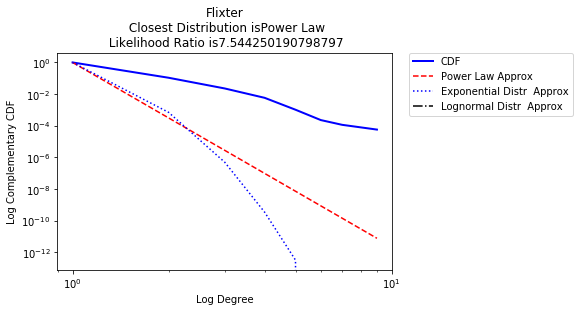

Plotting Graph for Facebook


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['Facebook', 'Power Law', 1860.876810530701]
1.4643639694364228
1.0


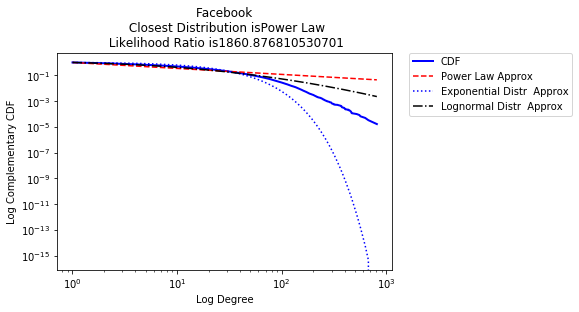

Plotting Graph for Linux Kernel Mailing List


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/powerlaw.py:2726: RuntimeWarning: overflow encountered in multiply
  likelihoods = (data ** (k - 1)) / (exp(data / theta) * (theta ** k) * float(gammainc(k)))


['Linux Kernel Mailing List', 'Power Law', 0.04335889834681694]
3.1672226391947893
1.0


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


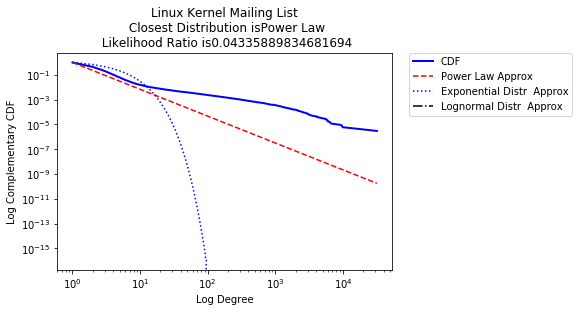

Plotting Graph for M2Anonymized.csv


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['M2Anonymized.csv', 'truncated_power_law', -1952.4385961482747]
1.5942925342106968
7.0


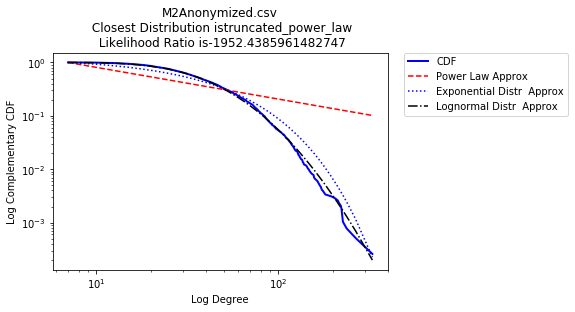

Plotting Graph for L1Anonymized.csv


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['L1Anonymized.csv', 'stretched_exponential', -1.992876632799235]
1.7342169331175432
1.0


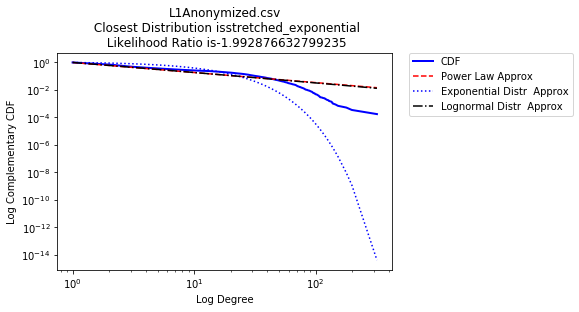

Plotting Graph for M1Anonymized.csv


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['M1Anonymized.csv', 'exponential', -606.6878545478527]
1.4594930461563103
2.0


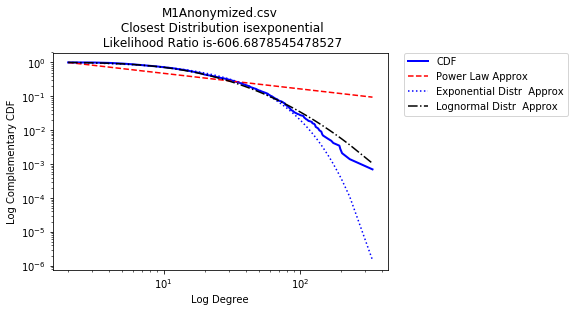

Plotting Graph for L2Anonymized.csv


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['L2Anonymized.csv', 'exponential', -3521.494496270177]
1.4003087165573995
2.0


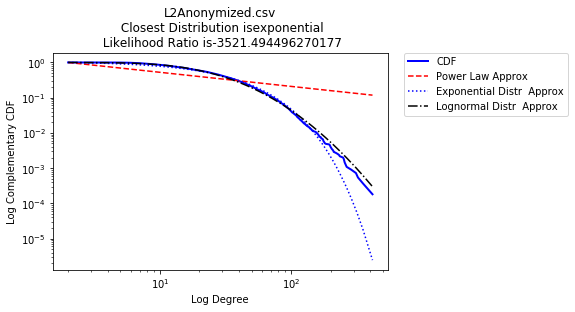

Plotting Graph for S2Anonymized.csv
['S2Anonymized.csv', 'lognormal', -31.350016312712786]
1.5762844600657877
1.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


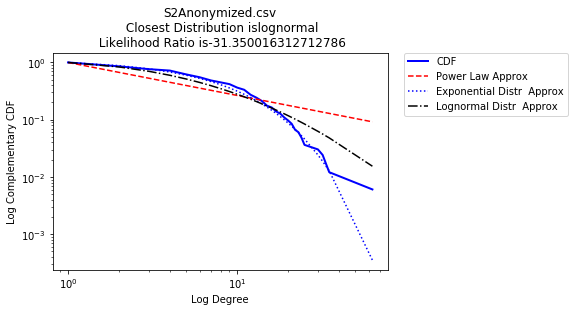

Plotting Graph for S1Anonymized.csv


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['S1Anonymized.csv', 'lognormal', -79.43053639091542]
1.6141165791318572
2.0


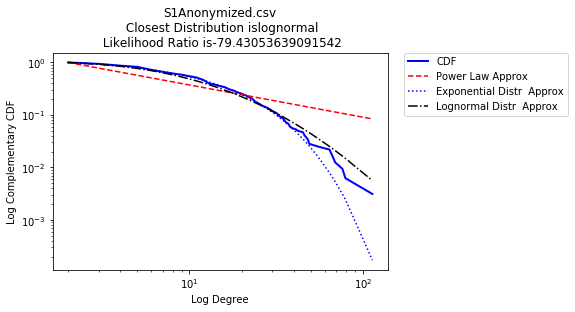

Plotting Graph for Dolphin_social_network_Dolphins
['Dolphin_social_network_Dolphins', 'lognormal', -16.43738389120839]
1.7085268069694566
1.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


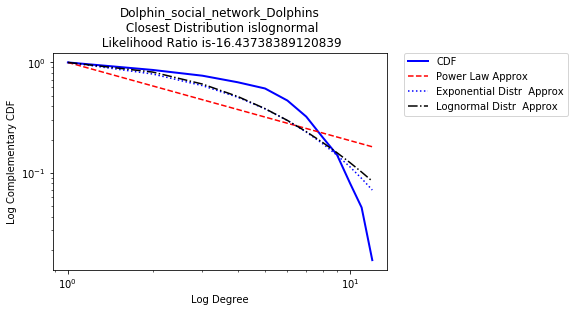

Plotting Graph for Email_network_Uni_R-V_Spain_Email_network_Uni_R-V_Spain


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['Email_network_Uni_R-V_Spain_Email_network_Uni_R-V_Spain', 'lognormal', -205.3156902473826]
1.5610894708096716
1.0


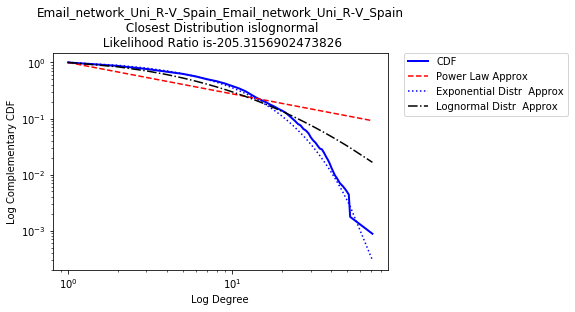

Plotting Graph for Family_planning_in_Korea1
['Family_planning_in_Korea1', 'lognormal', -5.730921221473371]
1.8450473205098805
1.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


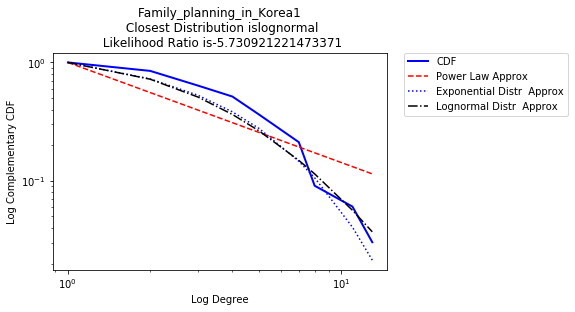

Plotting Graph for Family_planning_in_Korea2
['Family_planning_in_Korea2', 'lognormal', -12.955452123449412]
1.7235641237939854
1.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


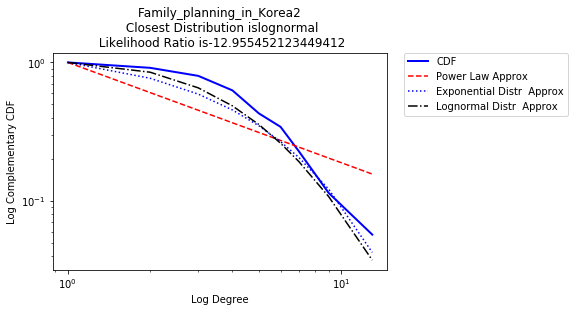

Plotting Graph for High_school_dynamic_contact_networks_contact_list,_2011
['High_school_dynamic_contact_networks_contact_list,_2011', 'truncated_power_law', -104.66462855344109]
1.4063505664264782
2.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


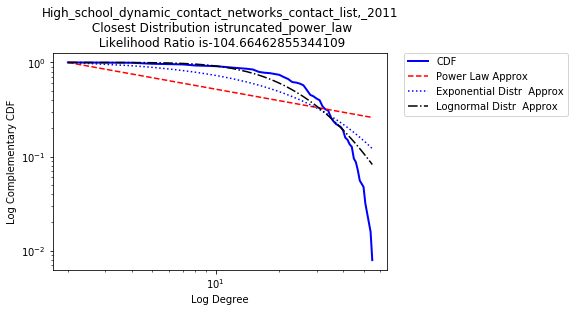

Plotting Graph for High_school_dynamic_contact_networks_contact_list,_2012
['High_school_dynamic_contact_networks_contact_list,_2012', 'exponential', -147.6199728778755]


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


1.4200737417467433
2.0


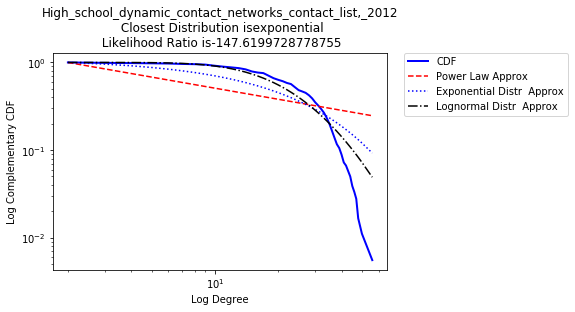

Plotting Graph for Hollywood_film_music_Hollywood_film_music
['Hollywood_film_music_Hollywood_film_music', 'lognormal', -21.987590367218075]
1.8849851457802398
1.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


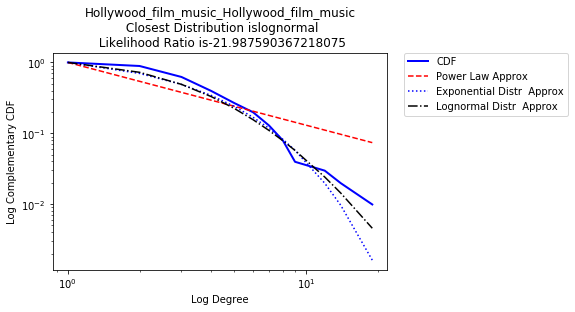

Plotting Graph for Kapferer_tailor_shop_Kapferer_tailor_shop_1
['Kapferer_tailor_shop_Kapferer_tailor_shop_1', 'truncated_power_law', -23.597027315625848]
1.5086076448080419
1.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


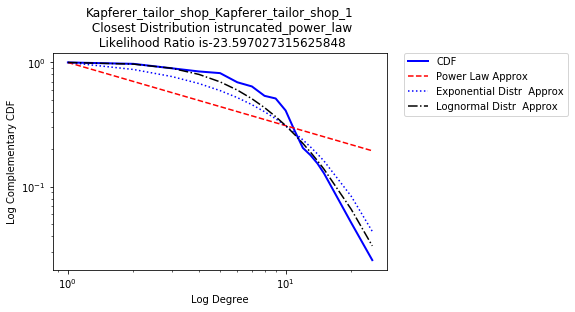

Plotting Graph for Kapferer_tailor_shop_Kapferer_tailor_shop_2
['Kapferer_tailor_shop_Kapferer_tailor_shop_2', 'truncated_power_law', -15.97758107071677]
1.7617036903884253
3.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


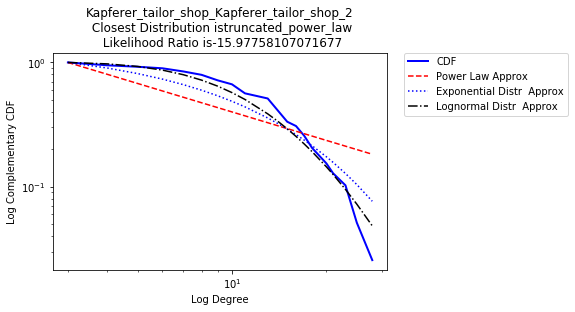

Plotting Graph for Les_Miserables_coappearances_Les_Miserables
['Les_Miserables_coappearances_Les_Miserables', 'lognormal', -6.571579263972439]
1.6911287053194672
1.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


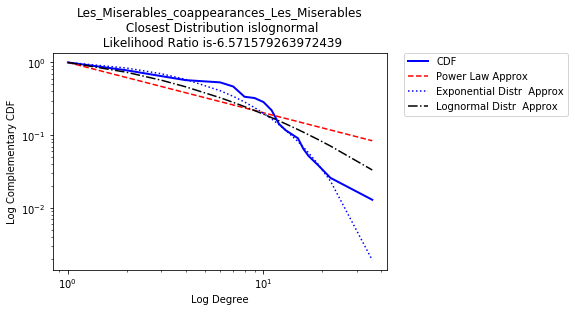

Plotting Graph for NCAA_college_football_2000_American_College_Football


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['NCAA_college_football_2000_American_College_Football', 'truncated_power_law', -21.871476277257475]
3.398679720357113
7.0


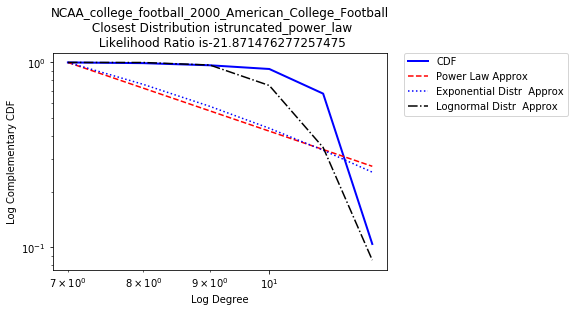

Plotting Graph for Norwegian_Board_of_Directors_net1mode_2011-08-01


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['Norwegian_Board_of_Directors_net1mode_2011-08-01', 'truncated_power_law', -258.6835963704462]
1.9528233931495664
2.0


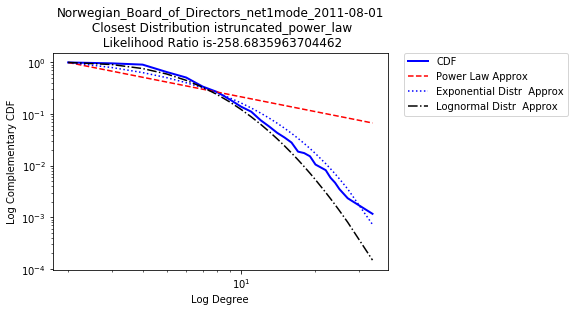

Plotting Graph for Zachary_Karate_Club_Zachary_karate_club_77
['Zachary_Karate_Club_Zachary_karate_club_77', 'exponential', -6.922635614170676]
1.8090431523063981
1.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


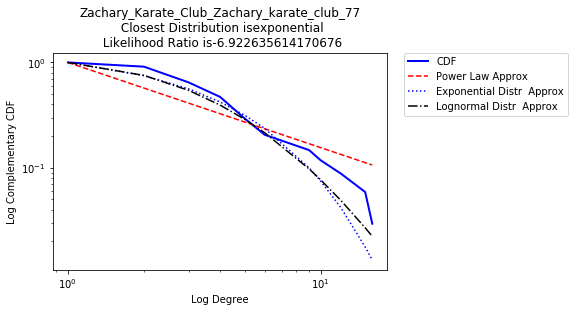

Plotting Graph for Zachary_Karate_Club_Zachary_karate_club_78
['Zachary_Karate_Club_Zachary_karate_club_78', 'truncated_power_law', -8.502010526394878]
1.780955527599628
1.0


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


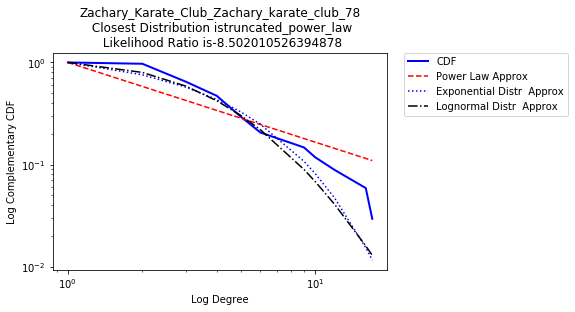

Plotting Graph for Sociology Students of Groningen


Analyzing all distributions
Calculating power law fit
Calculating truncated power law fit
Assuming nested distributions
Calculating exponential fit
Calculating lognormal fit
Calculating stretched_exponential fit
Calculating gamma fit


['Sociology Students of Groningen', 'truncated_power_law', -1.9218627175429017]
8.455256797420788
28.0


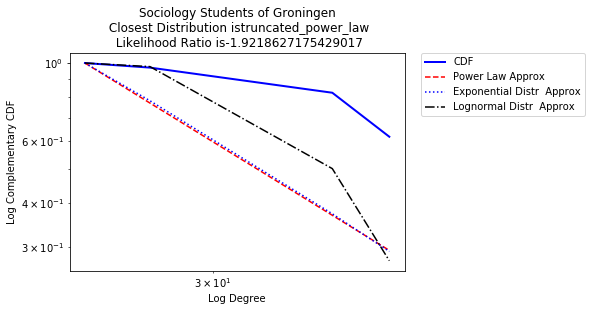

In [435]:
plot_theoretical_distributions(dict_of_networks)